# GD08. GO/STOP! - Object Detection 시스템 만들기

### ✅ 실습 목표

--------------------------------------------------

1. 바운딩 박스(bounding box) 데이터셋을 전처리할 수 있습니다.
2. Object detection 모델을 학습할 수 있습니다.
3. Detection 모델을 활용한 시스템을 만들 수 있습니다.

### ✅ 학습 내용

----------------------------------------

1. 자율주행 보조장치
2. RetinaNet
3. keras-retinanet
4. 프로젝트: 자율주행 보조 시스템 만들기


필요한 라이브러리 가져오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw


In [2]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"),"aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir = data_dir,
    split=['train','test'],
    shuffle_files=True,
    with_info=True,
)

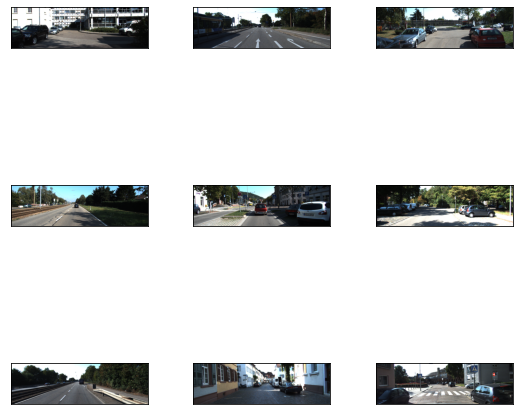

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

## 데이터 직접 확인하기

--------Example---------
['image', 'image/file_name', 'objects']
--------objects--------
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([-2.01,  1.92, -1.93, -1.8 , -1.75,  1.65, -1.7 ], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.18186666, 0.74190015, 0.49984   , 0.8036715 ],
       [0.00266667, 0.08744767, 0.48042667, 0.3595974 ],
       [0.00266667, 0.6150725 , 0.53128   , 0.90697265],
       [0.21274666, 0.574058  , 0.49658668, 0.69640905],
       [0.31757334, 0.54619163, 0.54981333, 0.63347024],
       [0.42213333, 0.41983092, 0.52672   , 0.457971  ],
       [0.41965333, 0.5287842 , 0.55461335, 0.5732367 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.44, 0.36, 1.26],
       [1.46, 1.6 , 3.33],
       [1.64, 1.7 , 3.54],
       [1.37, 1.51, 3.39],
       [1.74, 1.66, 4.23],
       [1.55, 1.68, 4.42],
       [2.  , 1.76, 4.61]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dt

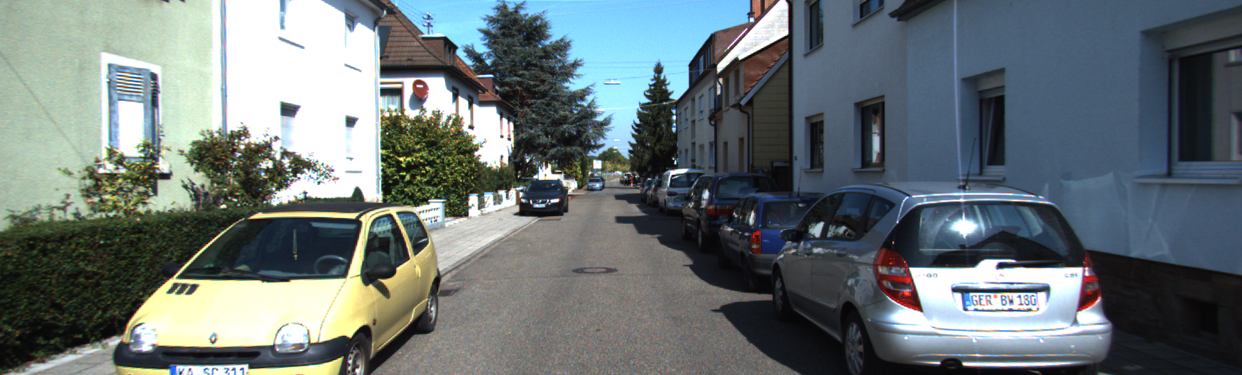

In [5]:
sample = ds_train.take(1)

for example in sample:
    print('--------Example---------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]
    
    
print('--------objects--------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(7, 4)
[921.44 306.8  998.16 187.56]
[108.61 374.   446.62 194.84]
[ 763.92004  374.      1126.4601   175.77   ]
[712.98004 295.22    864.94006 188.78   ]
[678.37 255.91 786.77 168.82]
[521.43    216.7     568.8     177.48001]
[656.75    217.63    711.95996 167.01999]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FB3E05940D0>


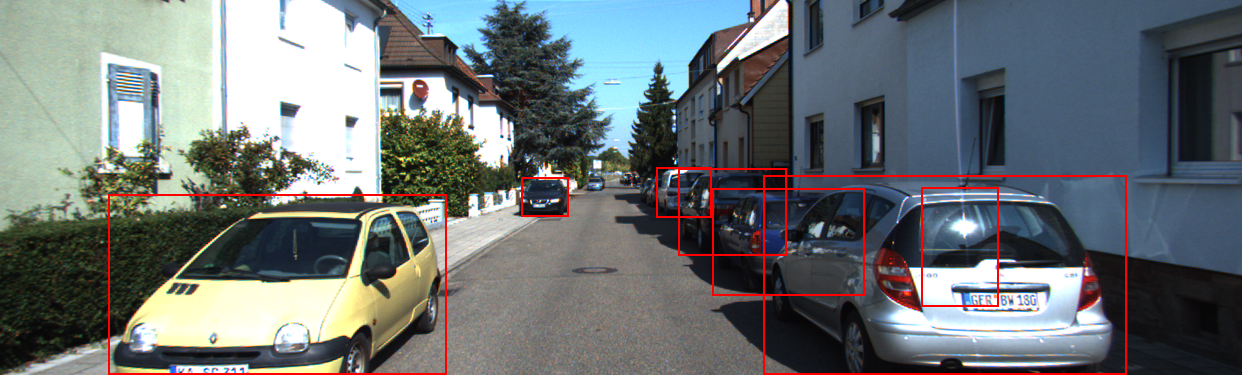

In [6]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())


## 데이터 포맷 변경

### 클래스 및 바운딩 박스 정보 추출

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)


100%|██████████| 6347/6347 [22:27<00:00,  4.71it/s]


In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:35<00:00,  4.56it/s]


### 클래스 맵핑

In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


## 셋팅

In [11]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-10-20 01:36:36.798798: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-20 01:36:38.718243: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-20 01:36:38.719221: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-20 01:36:38.728745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-20 01:36:38.728786: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-20 01:36:38.731725: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-20

학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환

In [12]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-10-20 02:21:00.612490: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-20 02:21:02.233736: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-20 02:21:02.234690: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-20 02:21:02.242738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-20 02:21:02.242778: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-20 02:21:02.246307: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-20

In [13]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[593.258   174.94684 626.65314 205.7895 ]
[177.00996 133.21178 368.0911  237.0338 ]
[371.23987 184.26201 420.53012 211.0088 ]
[534.24286 159.69641 565.7249  189.95097]
[441.0293  175.13908 472.97635 199.63863]


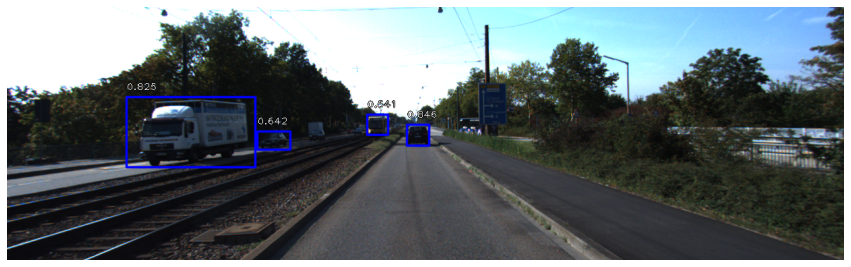

In [18]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

[770.10736 146.4337  835.515   308.4661 ]
[795.2193  156.10587 850.6009  287.53622]


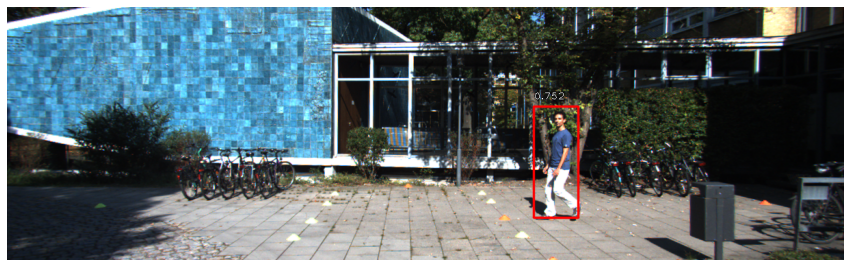

In [19]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

# ⭐️ 프로젝트: 자율주행 보조 시스템 만들기

## 1. 자율주행 시스템 만들기

----------------------------------

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

* 입력으로 이미지 경로를 받습니다.
* 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
* 조건은 다음과 같습니다.    

    * 사람이 한 명 이상 있는 경우
    * 차량의 크기(width or height)가 300px이상인 경우

[769.7419  142.61024 851.0809  312.0762 ]
[769.00696 143.55025 853.0741  307.2192 ]


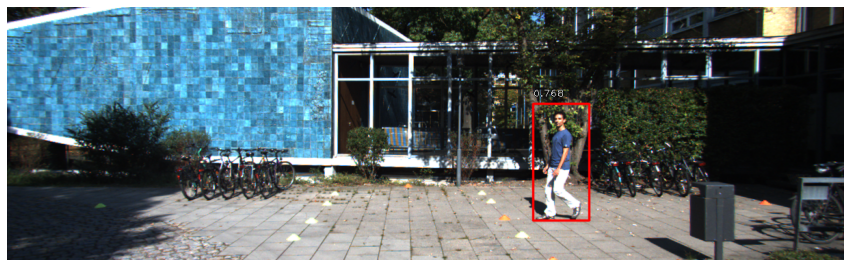

Stop


In [23]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0)  # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if visualize:
        result = 'Go'
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:  # 일정 점수 이하는 제외
                break
            b = box.astype(int)
            w = b[2]-b[0]
            h = b[3]-b[1]
            
            if w >= size_limit or h >= size_limit or label == 1:
                result = 'Stop'
            else:
                result = 'Go'
            
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        
        return result
    
print(self_drive_assist(img_path))

## 2. 자율주행 시스템 평가하기

----------------------------------


아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다.      
10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

[769.7419  142.61024 851.0809  312.0762 ]
[769.00696 143.55025 853.0741  307.2192 ]


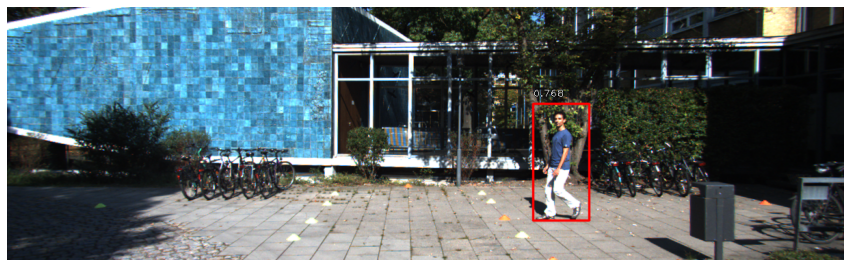

[419.8752  150.08955 498.54437 325.8243 ]
[383.38824 157.2007  534.2522  344.184  ]


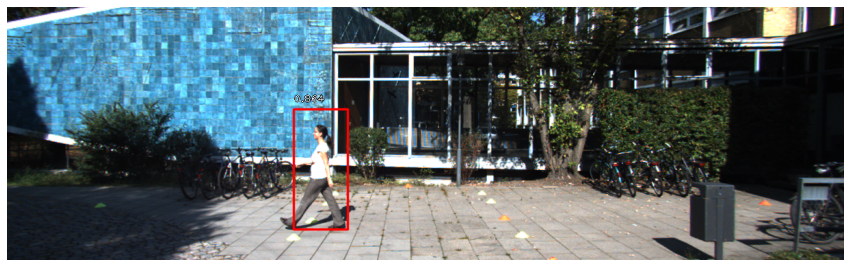

[753.2151  158.9376  874.3955  211.90134]
[  0.      200.52817 308.08737 369.12827]
[ 991.968    144.48726 1029.7733   214.67584]
[ 987.6373   147.00005 1031.9425   214.86328]


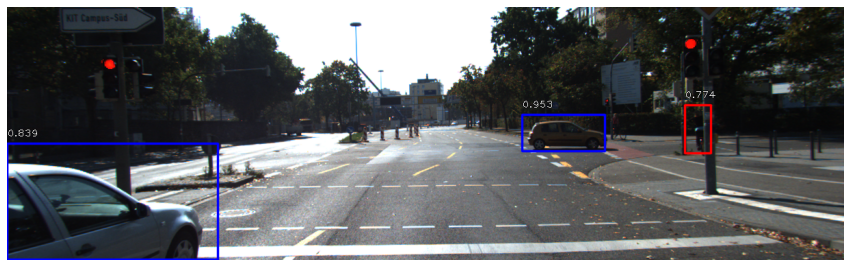

[650.2839  144.82857 737.5561  224.94106]
[445.36185 159.90257 554.28485 208.95485]
[ 698.58435   66.99857 1096.771    373.6249 ]
[354.0352  171.10338 473.5853  222.28171]
[ 18.561947 145.20488  374.6793   318.82523 ]
[386.8983  165.04852 530.9764  216.19363]
[147.71603 158.81837 365.03888 298.6841 ]


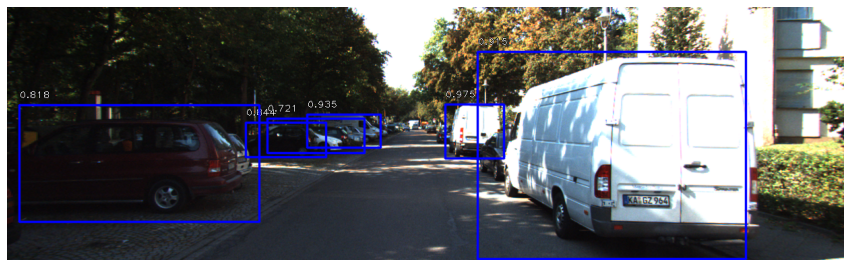

[ 859.8168   164.04318 1236.2838   373.6249 ]
[734.88007 162.68016 853.74164 250.8165 ]
[700.1065  148.3888  780.7152  217.28139]
[567.3911  181.12178 613.3946  215.5817 ]
[710.7492  153.18506 822.13446 235.5349 ]
[584.3799  179.27563 622.61005 208.95753]


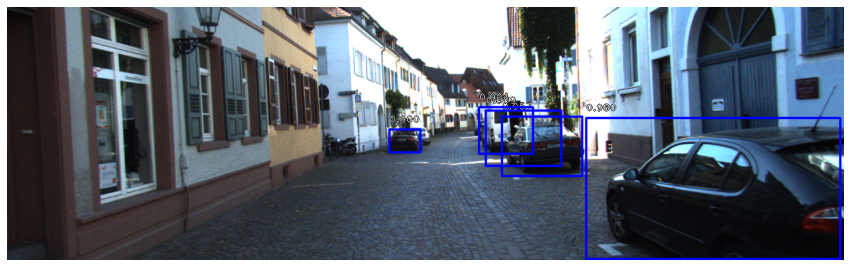

[186.11913 133.3263  357.47388 233.15193]
[592.04956 175.59525 624.7976  204.73746]
[375.76382 183.42354 418.49606 210.97983]
[530.94183 161.92682 564.5022  190.8572 ]
[441.72083 175.62047 473.0489  199.52567]


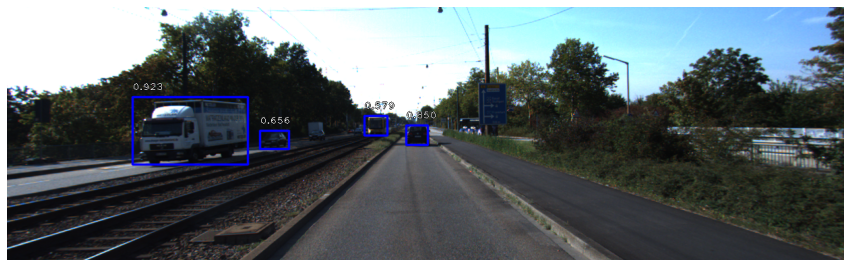

[515.45996 180.15656 567.6276  213.86725]
[627.49713 177.89317 667.48834 213.11865]
[531.6083  176.02081 578.1501  207.83621]


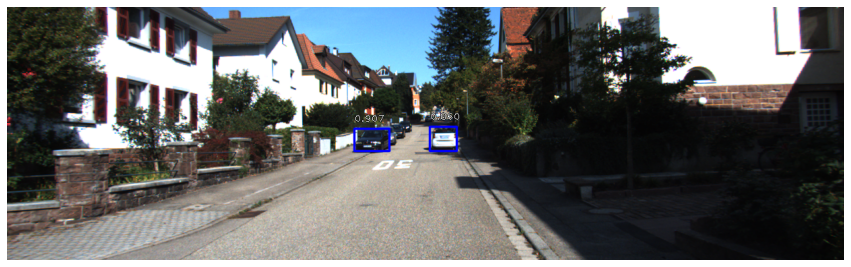

[812.63715 147.5722  886.61536 178.87718]
[320.2699  148.5638  400.56924 189.86943]
[538.8567 166.5547 569.9748 191.2175]


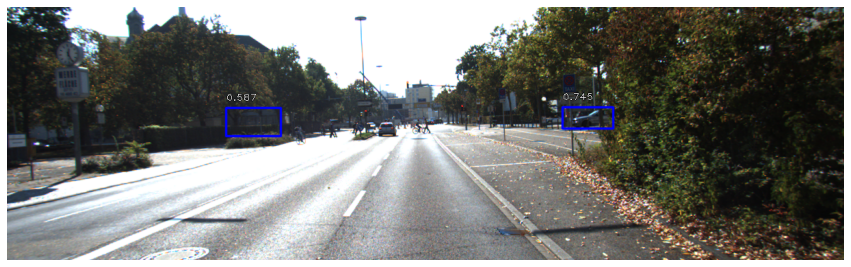

[690.6438  172.10028 787.773   255.38849]
[598.1019  177.0768  645.7269  203.04242]


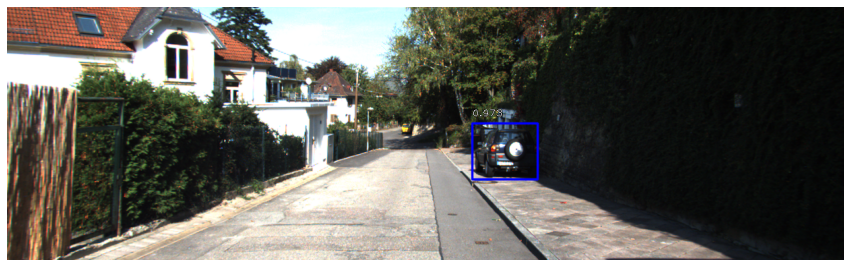

[  0.      190.33762 215.32811 308.8092 ]
[165.7514  183.88084 342.79266 262.1477 ]
[210.69453 177.82288 368.4796  244.47282]
[1090.1439   142.06435 1239.0477   205.6292 ]
[325.51245 178.02113 422.06238 226.04568]
[435.677   175.98949 491.70972 209.6809 ]
[ 896.9947   143.14076 1057.8884   196.32652]
[257.45117 176.03238 395.8459  231.93733]
[ 98.332886 187.26477  298.19388  268.61746 ]
[804.2957  155.12828 906.21515 193.50519]
[ 951.80774  145.85826 1113.7511   204.47722]
[460.65186 177.88345 505.19522 205.13426]


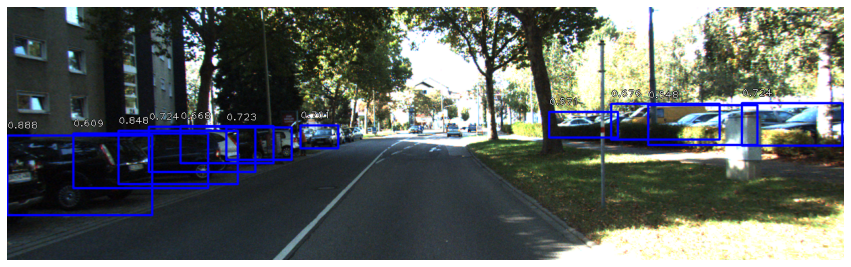

80점입니다.


In [24]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

# 🌟 루브릭

|평가문항|상세기준|
|:-----------|:----------------|
|1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.|KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.|
|2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.|바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.|
|3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.|테스트 수행결과 90% 이상의 정확도를 보였다.|

# 🌟 회고

Error : keras-retinanet error가 떠서 
> $ git clone https://github.com/fizyr/keras-retinanet.git      

> $ cd keras-retinanet && python setup.py build_ext --inplace       
        
> $ pip install -r requirements.txt    
한 후에 아래까지 해주었더니 에러가 사라졌다.   
> /opt/conda/bin/python3.7 -m pip install --upgrade pip      

> $ pip install .